<a href="https://colab.research.google.com/github/caioitalo/projetos_estudos/blob/main/Estudos_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importação de libs relevantes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import userdata
import os
! pip install kaggle --quiet

# 1º Modelo de Machine Learning

Notebook baseado a partir desse link: https://www.youtube.com/watch?v=vAM2W6OXj-8

In [ ]:
# importando chave e usuário kaggle e acessando ao dataset desejado
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d renatosn/sao-paulo-housing-prices
!unzip "/content/sao-paulo-housing-prices.zip"

houses = pd.read_csv("data.csv")

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 73.5MB/s]
Archive:  /content/sao-paulo-housing-prices.zip
  inflating: data.csv                


In [ ]:
houses.head()

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


In [ ]:
houses.shape

(11657, 8)

In [ ]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [ ]:
''' note que endereço e distritos possuem valores altos demais comparando com o tamanho do dataset. isso prejudica a análise pois tem muitos valores não unicos não numéricos.
colunas com mais de 50% do tamanho do dataset começam a não ajudar na análise
'''
houses.nunique()

address     5348
district    1199
area         381
bedrooms       7
garage         7
type           4
rent        1662
total       5571
dtype: int64

In [ ]:
houses = houses.drop(columns=['address', 'district'])

In [ ]:
#criação de uma coluna que une em booleano pois quartos e garagem aumentará diretamente o valor aluguel. OBS: note os parenteses de cada condição
houses['bedroom_and_garage'] = np.where((houses['bedrooms'] > 0) & (houses['garage'] > 0), 1, 0)

houses['extra_cost'] = houses['total'] - houses['rent']

(array([7.135e+03, 2.921e+03, 7.910e+02, 3.870e+02, 2.150e+02, 2.070e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  500.,  2950.,  5400.,  7850., 10300., 12750., 15200., 17650.,
        20100., 22550., 25000.]),
 <BarContainer object of 10 artists>)

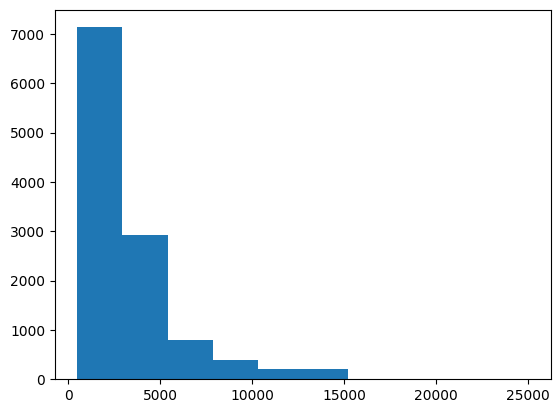

In [ ]:
plt.hist(houses['rent'])

(array([1.120e+02, 7.720e+02, 2.260e+03, 2.530e+03, 2.726e+03, 1.591e+03,
        8.410e+02, 5.090e+02, 3.150e+02, 1.000e+00]),
 array([ 6.2146081,  6.6058104,  6.9970127,  7.388215 ,  7.7794173,
         8.1706196,  8.5618219,  8.9530242,  9.3442265,  9.7354288,
        10.1266311]),
 <BarContainer object of 10 artists>)

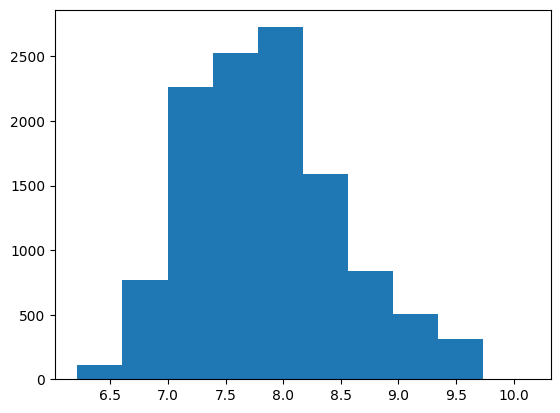

In [ ]:
plt.hist(np.log(houses['rent']))

## Modelo Preditivo

> Antes de tudo separe seu dataset em treino e teste. Para os dados de um não "vazarem" para o outro

In [ ]:
from sklearn.model_selection import train_test_split

X = houses.drop(['rent', 'total'], axis=1) # entender depois porque ele dropou
Y = houses['rent']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# um bom número para o tamanho dos dados de teste é de 20%, random_state é um número relativo ao nível de embaralhamento dos datasets, 42 é o padrão


In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((9325, 6), (2332, 6), (9325,), (2332,))

### Método sem pipeline e ColumnTransformer

In [ ]:
categorical_features = ['type']
#numerical_features2 = ['area', 'rent', 'total', 'extra_cost', 'bedroom_and_garage'] deu erro na criação do X_train_processed, mas esse era o original
numerical_features = ['area', 'extra_cost', 'bedroom_and_garage']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first') #procurar a respeito disso
X_train_categorical = ohe.fit_transform(X_train[categorical_features])
X_test_categorical = ohe.transform(X_test[categorical_features])

In [ ]:
X_train_categorical

<9325x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3572 stored elements in Compressed Sparse Row format>

In [ ]:
# criando um pandas DF de dados processados, mas antes é necessário transformar de uma matriz numpy para uma array.
# note o reset_index por conta de na concatenação ele tentar unir pelos indexes dos dois dfs, ao resetar e dropar previne esse comportamento inesperado
X_train_processed = pd.concat([pd.DataFrame(X_train_categorical.toarray()), X_train[numerical_features].reset_index()], axis=1)
X_test_processed = pd.concat([pd.DataFrame(X_test_categorical.toarray()), X_test[numerical_features].reset_index()], axis=1)

X_train_processed = X_train_processed.drop(columns='index')
X_test_processed = X_test_processed.drop(columns='index')

In [ ]:
X_train_processed

,0,1,2,area,extra_cost,bedroom_and_garage
0,0.0,0.0,0.0,80,698,1
1,1.0,0.0,0.0,70,265,0
2,0.0,1.0,0.0,175,151,0
3,1.0,0.0,0.0,375,1970,1
4,0.0,0.0,0.0,60,790,1
...,...,...,...,...,...,...
9320,0.0,0.0,0.0,156,2220,1
9321,0.0,0.0,0.0,50,592,1
9322,0.0,0.0,0.0,65,849,1
9323,0.0,0.0,0.0,60,1274,1


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
xgb = XGBRegressor() # pesquisar mais a fundo o que é o XGB

#aqui ele fica "olhando" as colunas e procurando os padrões que diminuem a função erro
xgb.fit(X_train_processed, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
Y_pred = xgb.predict(X_test_processed)

In [ ]:
mse = mean_squared_error(Y_test, Y_pred)
print(f"mean squared error:{mse}")

mean squared error:2706357.4654585994


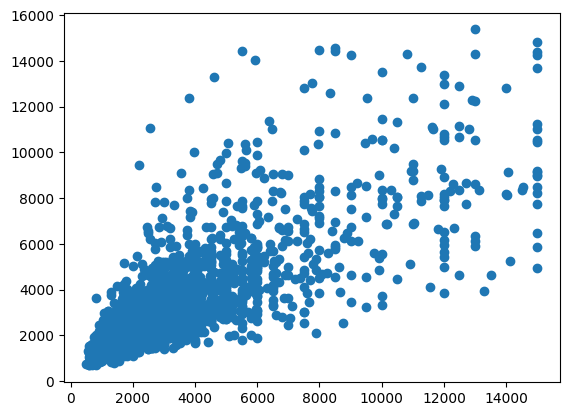

In [ ]:
#eixo x é o que aconteceu, eixo y foi a previsão. a situação ideal é que esteja mais próximo da reta diagonal
plt.scatter(Y_test, Y_pred)

## Usando column transformer

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

categorical_features = ['type']
#numerical_features2 = ['area', 'rent', 'total', 'extra_cost', 'bedroom_and_garage'] deu erro na criação do X_train_processed, mas esse era o original
numerical_features = ['area', 'extra_cost', 'bedroom_and_garage']

transformations = [
    ('ohe', OneHotEncoder(drop='first'), categorical_features),
    ('scaler', StandardScaler(), numerical_features)
]

preprocessor = ColumnTransformer(transformers = transformations)

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train, Y_train)
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
xgb.fit(X_train_transformed, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
Y_pred = xgb.predict(X_test_transformed)

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f'RMSE:{rmse}')

mae = mean_absolute_error(Y_test, Y_pred)
print(f'MAE:{mae}')

mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
print(f'MAPE:{mape:.2f}%')


RMSE:1645.1010502271888
MAE:1005.4941344482003
MAPE:31.94%


#Regressão Linear

In [ ]:
!pip install wooldridge

In [ ]:
import pandas as pd
from wooldridge import *
import statsmodels.formula.api as smf

In [ ]:
gpa = dataWoo("GPA2")

FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.10/dist-packages/wooldridge/datasets/GPA2.csv.bz2'

In [ ]:
results = smf.ols('colgpa ~ hsperc + sat', data=gpa).fit()
print = (results.summary())

# Atividade - Usando RL para prever custo médicos

In [3]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d mirichoi0218/insurance
!unzip "/content/insurance.zip"

df_insurance = pd.read_csv("insurance.csv")

  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 30.5MB/s]
Archive:  /content/insurance.zip
  inflating: insurance.csv           


In [4]:
df_insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [5]:
df_insurance.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [6]:
df_insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


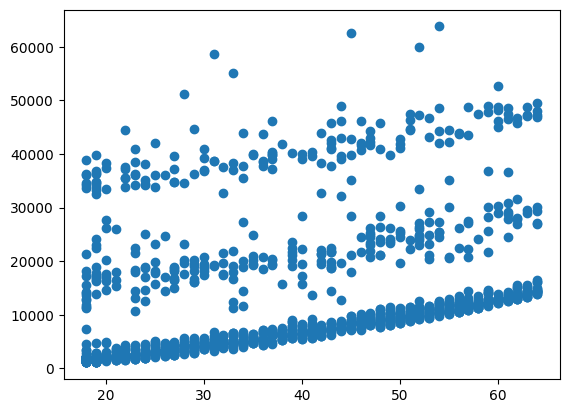

In [7]:
plt.scatter(df_insurance['age'], df_insurance['charges'])

In [8]:
df_insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [9]:
df_insurance = df_insurance.drop(columns=['bmi'])

<BarContainer object of 1338 artists>

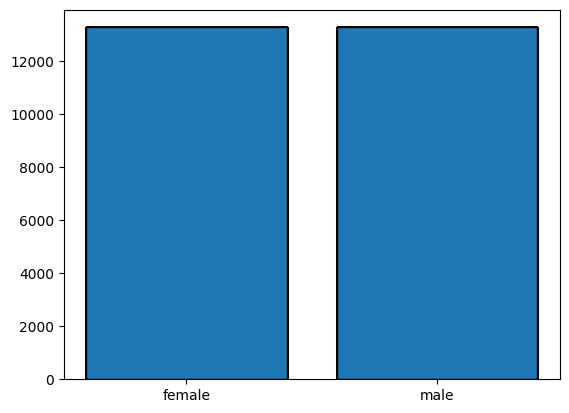

In [10]:
plt.bar(df_insurance['sex'], df_insurance['charges'].mean(), edgecolor="black",)

(array([536., 398., 129.,  86.,  35.,  59.,  57.,  32.,   2.,   4.]),
 array([ 1121.8739  ,  7386.729311, 13651.584722, 19916.440133,
        26181.295544, 32446.150955, 38711.006366, 44975.861777,
        51240.717188, 57505.572599, 63770.42801 ]),
 <BarContainer object of 10 artists>)

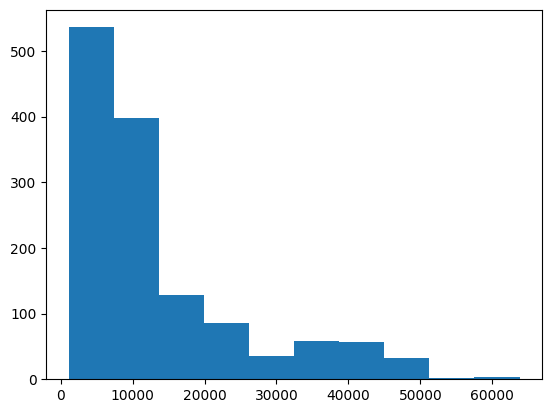

In [11]:
plt.hist(df_insurance['charges'])

In [12]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
reg = linear_model.LinearRegression()

In [13]:
X = df_insurance.drop(columns=['charges'])
y = df_insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)